# Project overview
## Data prep

1.   Load Images
2.   Convert RGB to Grey Scale
3.   Reduce Image size
4.   Normalize
5.   Reshape

## Model


1.   Use CNN with 200 kernals of size 3x3
2.   Use CNN with 100 kernals of size 3x3
3.   Flaten layer
4.   Dense layer of size 50x1
5.   Dense layer of size 2 to Classify with mask or without mask category

Note: No pre trained model has been used





## Data Prep

In [0]:
import cv2, os

In [0]:
data_path='/content/drive/My Drive/Colab Notebooks/Face Mask Detection/Dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

{'With Mask': 0, '.ipynb_checkpoints': 1, 'Without Mask': 2}
['With Mask', '.ipynb_checkpoints', 'Without Mask']
[0, 1, 2]


In [0]:
label_dict.pop('.ipynb_checkpoints')

1

In [0]:
label_dict

{'With Mask': 0, 'Without Mask': 2}

In [0]:
img_size=100
data=[]
target=[]


In [0]:
label_dict['Without Mask']=1

In [0]:
label_dict

{'With Mask': 0, 'Without Mask': 1}

In [0]:
for cat in categories:
    folder_path= os.path.join(data_path,cat)
    images= os.listdir(folder_path)
    for image in images:
        img_path= os.path.join(folder_path, image)
        img= cv2.imread(img_path)

        try:
            gray_img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img= cv2.resize(gray_img, (img_size, img_size))
            data.append(resized_img)
            target.append(label_dict[cat])
        except Exception as e:
            print('Exception', e)

In [0]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

In [0]:
from keras.utils import np_utils

new_target=np_utils.to_categorical(target)
np.save('data',data)
np.save('target',new_target)

## Modeling Architechture
1. cov2D 200@3x3 followed by Activation and Maxpooling Layer
2. cov2D 100@3x3 followed by Activation and Maxpooling Layer
3. Flatten Layer followed by Drop Out layer
4. Dense layer 50
5. Dense Layer 2


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dropout, Dense

In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
data.shape

(2752, 100, 100, 1)

In [0]:
model= Sequential()
# Concolution Layer 1
model.add(Conv2D(200, (3,3), input_shape= data.shape[1:] ))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size= (2,2)))

# Concolution Layer 2
model.add(Conv2D(100, (3,3) ))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size= (2,2)))

# Faltten
model.add(Flatten())

# Drop Out
model.add(Dropout(.5))

# Dense 1
model.add(Dense(50, activation= 'relu'))

# Dense 2
model.add(Dense(2, activation= 'softmax'))

# Compile for output with two categories
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics =['accuracy'])

## Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target= train_test_split(data, target, test_size=.1)

## Run the Model

In [0]:
from keras.utils import to_categorical
train_target1 = to_categorical(train_target.tolist())
test_target1 = to_categorical(test_target.tolist())

In [0]:
print(train_data.shape)
print(train_target1.shape)

(2476, 100, 100, 1)
(2476, 2)


In [0]:
checkpoint= ModelCheckpoint('model-{epoch:03d}.model', save_best_only=True)
history= model.fit(train_data, train_target1, epochs=20, callbacks=[checkpoint], validation_split=.2)

Train on 1980 samples, validate on 496 samples
Epoch 1/20
1980/1980 [==============================] - 152s 77ms/step - loss: 0.6008 - accuracy: 0.6662 - val_loss: 0.3994 - val_accuracy: 0.8165
Epoch 2/20
1980/1980 [==============================] - 153s 77ms/step - loss: 0.3239 - accuracy: 0.8606 - val_loss: 0.1838 - val_accuracy: 0.9133
Epoch 3/20
1980/1980 [==============================] - 150s 76ms/step - loss: 0.1785 - accuracy: 0.9318 - val_loss: 0.1146 - val_accuracy: 0.9556
Epoch 4/20
1980/1980 [==============================] - 143s 72ms/step - loss: 0.1253 - accuracy: 0.9596 - val_loss: 0.0730 - val_accuracy: 0.9758
Epoch 5/20
1980/1980 [==============================] - 147s 74ms/step - loss: 0.0806 - accuracy: 0.9742 - val_loss: 0.0843 - val_accuracy: 0.9738
Epoch 6/20
1980/1980 [==============================] - 144s 73ms/step - loss: 0.0578 - accuracy: 0.9793 - val_loss: 0.1422 - val_accuracy: 0.9456
Epoch 7/20
1980/1980 [==============================] - 144s 73ms/step 

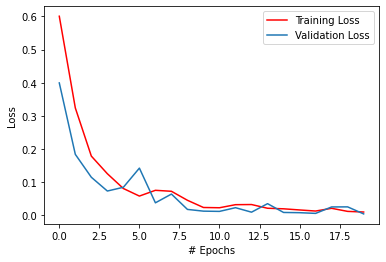

In [0]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], 'r', label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.show()

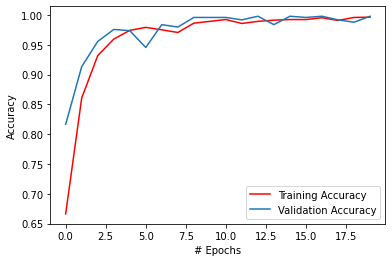

In [0]:
plt.plot(history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')
plt.show()

In [0]:
print(model.evaluate(test_data, test_target1))

276/276 [==============================] - 5s 19ms/step
[0.06248724451997196, 0.9927536249160767]


# Detecting Face Mask Live

In [2]:
from keras.models import load_model
import cv2

Using TensorFlow backend.


In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


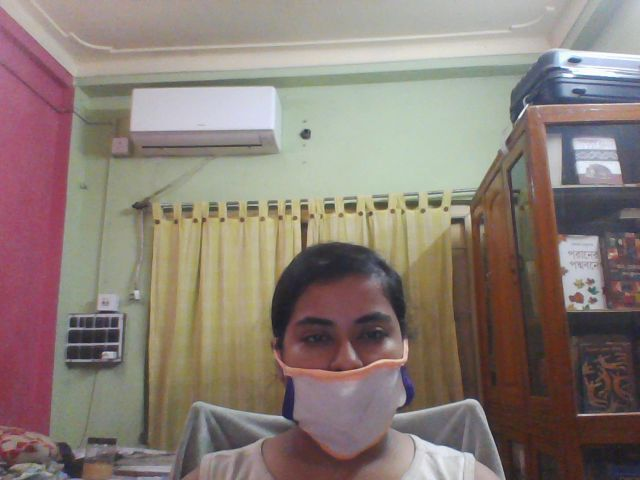

In [88]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [0]:
img= cv2.imread('/content/photo.jpg', cv2.IMREAD_UNCHANGED)
from google.colab.patches import cv2_imshow

In [90]:
gray_img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cascade_classifier.detectMultiScale(gray_img, 1.3, 5)

()

In [0]:
model= load_model('model-020.model')

cascade_classifier= cv2.CascadeClassifier('/content/drive/My Drive/Colab Notebooks/Face Mask Detection/haarcascade_frontalface_default.xml')

# source= cv2.VideoCapture(1)
label_dict= {0:'Mask', 1:'No Mask'}
color_dict= {0:(0,255,0), 1:(0,0,255)}

In [0]:
import numpy as np

result [[0.00256291 0.9974371 ]] label 1


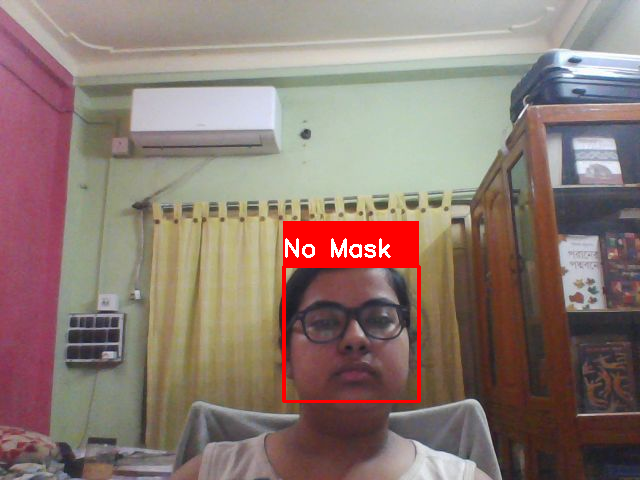

In [87]:
# while True:

gray_img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces= cascade_classifier.detectMultiScale(gray_img, 1.3, 5)

for x,y, w,h in faces:
    face_img= gray_img[y:y+h, x:x+w]
    resized= cv2.resize(face_img, (100,100))
    normalized= resized/255.0
    reshaped= np.reshape(normalized, (1,100,100,1))
    result= model.predict(reshaped)

    label= np.argmax(result, axis=1)[0]
    print('result', result, 'label', label)

    new_img= cv2.rectangle(img, (x,y), (x+w, y+h), color_dict[label], 2)
    new_img1= cv2.rectangle(new_img, (x,y-45), (x+w, y), color_dict[label], -1)
    new_img2= cv2.putText(new_img1, label_dict[label], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, .8, (255,255,255), 2)
# print(new_img1)
    cv2_imshow(img)
#     key= cv2.waitkey(1)
#     if key==27:
#       break

# cv2.destroyAllWindows()
# source.release()



In [83]:
cascade_classifier.detectMultiScale(gray_img, 1.3, 5)

()